In [1]:
# I am interested in figuring out what factors might impact a cats's chances of getting adopted (vs other outcomes)
# I'm working from a dataset of intakes and outcomes from a shelter in Texas (Austin Animal Center)
# I have previously cleaned this data, so I don't need to worry about duplicates, nulls, basic quality controls, etc. 
# My goal is to identify specific features I might use to model/predict a cat's chance of adoption. 

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_theme()
from ydata_profiling import ProfileReport
from scipy.stats.contingency import crosstab
#from scipy.stats import chi2_contingency
import re

In [3]:
# Import data
data = pd.read_csv('Intake and Outcome Data - Austin Animal Center.csv')
data = data.iloc[:,1:]
data.head()

Animal ID Animal Type Date of Birth      Sex                         Breed  \
0   A521520         Dog    09/07/2006   Female  Border Terrier/Border Collie   
1   A664235         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
2   A664237         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
3   A664236         Cat    09/24/2013  Unknown        Domestic Shorthair Mix   
4   A664233         Dog    09/30/2010   Female                  Pit Bull Mix   

          Color Intake Type Intake Condition  Intake Age  \
0     White/Tan       Stray           Normal        2555   
1  Orange/White       Stray           Normal           7   
2  Orange/White       Stray           Normal           7   
3  Orange/White       Stray           Normal           7   
4    Blue/White       Stray          Injured        1095   

  Intake Reproductive Status      Intake DateTime     Outcome DateTime  \
0                    Altered  2013-10-01 07:51:00  2013-10-01 15:39:00   
1                    Unknown  2013-10-01 08:33:00  2013-10-01 10:39:00   
2                    Unknown  2013-10-01 08:33:00  2013-10-01 10:44:00   
3                    Unknown  2013-10-01 08:33:00  2013-10-01 10:44:00   
4                     Intact  2013-10-01 08:53:00  2013-10-01 15:33:00   

      Outcome Type Outcome Subtype  Outcome Age Outcome Reproductive Status  
0  Return to Owner   Not Specified         2555                     Altered  
1         Transfer         Partner            7                     Unknown  
2         Transfer         Partner            7                     Unknown  
3         Transfer         Partner            7                     Unknown  
4       Euthanasia       Suffering         1095                      Intact

In [4]:
# Converting strings to numerical values
data['Intake DateTime'] = pd.to_datetime(data['Intake DateTime'], format = '%Y-%m-%d %H:%M:%S')
data['Outcome DateTime'] = pd.to_datetime(data['Outcome DateTime'], format = '%Y-%m-%d %H:%M:%S')
data['Date of Birth'] = pd.to_datetime(data['Date of Birth'], format = '%m/%d/%Y')

In [5]:
# I expect that the factors that impact a dog's chances of adoption might differ than those of a cat, livestock, or exotic animal.
# I'm focusing on cats in this exploration, so I don't need to continue with all the other species' data. 

#dogs = data.loc[data['Animal Type'] == 'Dog']
#bird = data.loc[data['Animal Type'] == 'Bird']
#livestock = data.loc[data['Animal Type'] == 'Livestock'] #this dataset is pretty small - only about 30 animals, so barely enough data to interpret!
#exotics = data.loc[data['Animal Type'] == 'Other']

cats = data.loc[data['Animal Type'] == 'Cat']
cats['Outcome Type'].unique()

array(['Transfer', 'Euthanasia', 'Adoption', 'Died', 'Return to Owner',
       'Missing', 'Disposal', 'Rto-Adopt', 'Relocate', 'Lost'],
      dtype=object)

In [6]:
# Pet's with presenting as Euthanasia Request will never be adopted out, so these won't answer my question in a meaningful way. 
# So I will get rid of that intake type
# Same for Lost and Missing as outcome types; these aren't intentional outcomes, so they won't answer my question meaningfully (and are hopefully infrequent)

cats = cats.loc[(cats['Intake Type'] != 'Euthanasia Request') &
                ((cats['Outcome Type'] != 'Lost') &
                (cats['Outcome Type'] != 'Missing') )]


In [7]:
# Function to calculate the Duration of Stay in days
def calculate_stay(row):
    timedelta = row['Outcome DateTime'] - row['Intake DateTime']
    return timedelta.days

In [8]:
# I'd also like to track the length of stay in the shelter to see if the variables associated with adoption outcome also change how long it takes a pet to be adopted. 

cats['Duration of Stay'] = cats.apply(calculate_stay, axis = 1)
cats.head()

Animal ID Animal Type Date of Birth      Sex                   Breed  \
1   A664235         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
2   A664237         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
3   A664236         Cat    2013-09-24  Unknown  Domestic Shorthair Mix   
5   A664238         Cat    2013-06-01  Unknown  American Shorthair Mix   
7   A664256         Cat    1996-10-01     Male  Domestic Shorthair Mix   

               Color      Intake Type Intake Condition  Intake Age  \
1       Orange/White            Stray           Normal           7   
2       Orange/White            Stray           Normal           7   
3       Orange/White            Stray           Normal           7   
5        Black/White            Stray           Normal         120   
7  Brown Tabby/White  Owner Surrender           Normal        6205   

  Intake Reproductive Status     Intake DateTime    Outcome DateTime  \
1                    Unknown 2013-10-01 08:33:00 2013-10-01 10:39:00   
2                    Unknown 2013-10-01 08:33:00 2013-10-01 10:44:00   
3                    Unknown 2013-10-01 08:33:00 2013-10-01 10:44:00   
5                    Unknown 2013-10-01 09:33:00 2013-10-01 16:47:00   
7                    Altered 2013-10-01 10:59:00 2013-10-10 13:17:00   

  Outcome Type Outcome Subtype  Outcome Age Outcome Reproductive Status  \
1     Transfer         Partner            7                     Unknown   
2     Transfer         Partner            7                     Unknown   
3     Transfer         Partner            7                     Unknown   
5   Euthanasia         Medical          120                     Unknown   
7     Transfer         Partner         6205                     Altered   

   Duration of Stay  
1                 0  
2                 0  
3                 0  
5                 0  
7                 9

In [9]:
# The Animal Type is now a constant. So I can drop it. 

cats = cats.drop(columns = ['Animal Type'])
cats.head()

Animal ID Date of Birth      Sex                   Breed              Color  \
1   A664235    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
2   A664237    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
3   A664236    2013-09-24  Unknown  Domestic Shorthair Mix       Orange/White   
5   A664238    2013-06-01  Unknown  American Shorthair Mix        Black/White   
7   A664256    1996-10-01     Male  Domestic Shorthair Mix  Brown Tabby/White   

       Intake Type Intake Condition  Intake Age Intake Reproductive Status  \
1            Stray           Normal           7                    Unknown   
2            Stray           Normal           7                    Unknown   
3            Stray           Normal           7                    Unknown   
5            Stray           Normal         120                    Unknown   
7  Owner Surrender           Normal        6205                    Altered   

      Intake DateTime    Outcome DateTime Outcome Type Outcome Subtype  \
1 2013-10-01 08:33:00 2013-10-01 10:39:00     Transfer         Partner   
2 2013-10-01 08:33:00 2013-10-01 10:44:00     Transfer         Partner   
3 2013-10-01 08:33:00 2013-10-01 10:44:00     Transfer         Partner   
5 2013-10-01 09:33:00 2013-10-01 16:47:00   Euthanasia         Medical   
7 2013-10-01 10:59:00 2013-10-10 13:17:00     Transfer         Partner   

   Outcome Age Outcome Reproductive Status  Duration of Stay  
1            7                     Unknown                 0  
2            7                     Unknown                 0  
3            7                     Unknown                 0  
5          120                     Unknown                 0  
7         6205                     Altered                 9

#### Consolidating Descriptive Features

In [10]:
def consolidate (row, dict, column):
    key = row[column]
    new_value = dict.get(key, key)
    return new_value

In [11]:
# There are a few Outcome Types that seem like they can be bundled together: relocate and transfer both suggest going to another shelter elsewhere; died and disposal are likely similar enough, and Rto-Adopt and Return to Owner can 
# be consolidated (this is a judgement call, but given that the pet is returning to the owner in both cases, I'm choosing to prioritize the Rto part of "Rto-Adopt").

outcome_consolidation = {
        'Disposal': 'Died',
        'Rto-Adopt': 'Return to Owner',
        'Relocate': 'Transfer'}

cats['Outcome Type'] = cats.apply(consolidate, args= (outcome_consolidation, 'Outcome Type'), axis = 1)
# cats_to_change = (cats['Outcome Type'] == 'Disposal') | (cats['Outcome Type'] == 'Rto-Adopt') | (cats['Outcome Type'] == 'Relocate')
# cats.loc[cats_to_change, 'Outcome Type'] = cats.loc[cats_to_change, 'Outcome Type'].map(outcome_consolidation).fillna("unrecognized")

In [12]:
# The intake conditions can also be consolidated. 
# All neonates are nursing juveniles; these animals will need to stay in the shelter system until at least 8wks, so they may have a longer duration of stay
# Pregnant animals and nursing adult will stay until their kittens are weaned, so they may have a longer duration of stay.
# I'm consolidating Med Attn and Medical into the "sick" condition bc these are likely mild-moderate sicknesses. 
# I'm making a 'severe illness' category that will encompass panleuk, agonal, neurological, and med urgent as these codes suggest more serious levels of sickness
# Lastly, I'm consolidating "unknown", "other", and "space" into other because these are vague and infrequent.

intake_conditions = {
    'Neonatal': 'Nursing Juvenile',
    'Pregnant': 'Pregnant/Lactating',
    'Nursing Adult' : 'Pregnant/Lactating',
    'Medical' : 'Sick',
    'Med Attn' : 'Sick',
    'Unknown' : 'Other',
    'Space' : 'Other', 
    'Panleuk': 'Severe Illness', 
    'Agonal' : 'Severe Illness',
    'Neurologic' : 'Severe Illness', 
    'Med Urgent' : 'Severe Illness'
}

cats['Intake Condition'] = cats.apply(consolidate, args= (intake_conditions, 'Intake Condition'), axis = 1)

#### Initial Examination - Profiling Report

In [13]:
# Exploring data with ydata_profiling
cats_profile = ProfileReport(cats, title="Profiling Report")
cats_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Preprocessing Breed & Color Features

In [14]:
# The Profiling Report highlights the most frequently appearing words in the Breed and Color features, which suggests some ways these data could be further organized to make them into useable features. 

In [19]:
# The vast majority of cats in shelters are "mixed breed" Domestic Short/Medium/Long Hair cats. A smaller percentage might  truly be purebred cats, which might confer an adoption advantage. And some cats will be described as mixed with a purebred cat (ex. DSH/Siamese mix), which might still confer a benefit. 
# 
# I'd like to separate the "mixed breed" cats from the purebred cats by creating a new boolean feature. For my purposes, DSH/DMH/DLH are mixed breed. The shelter seems to use 'mix' or 'breed/breed'
# nomenclature to describe mixed breed cats, so I will use these flags to help me pick out mixes from purebreds. 

# To turn my breed data into a list of specific breeds, I'm doing the following: 
#   - Siamese mix -> Siamese; purebred = False
#   - Siamese/Angora -> Siamese and Angora, stored in the 'Breed' column & a new 'Breed2' column, purebred = False
#   - Domestic Shorthair/Mediumhair/Longhair -> purebred = False


# Compile the regex pattern for Domestic Shorthair variations
breed_pattern = re.compile(r"^(?:Domestic\s)?(Shorthair|Medium\sHair|Longhair|DSH|DMH|DLH|Mediumhair|Long\sHair)$", re.IGNORECASE)

def breed_parsing(row):
    # Extract breed information & set default values
    breed1 = row['Breed']
    breed2 = 'Not Provided'
    purebred = True

    # Mix breeds gets truncated to the identifying breed (ex. Siamese mix -> Siamese)
    # The secondary breed is 'Unknown'
    if 'Mix' in breed1:
        breed1 = breed1.replace(' Mix', '')
        breed2 = 'Unknown'
        purebred = False

    # Breeds with two listed breeds (identified by /) are stored as breed1 & breed2 
    # (ex. Siamese/Angora -> Siamese and Angora)
    if '/' in breed1:
        breed1, breed2 = breed1.split('/')
        purebred = False

    # Domestic Shorthair variants are flagged as mixed breed but not otherwise changed.  
    if re.search(breed_pattern, breed1):
        purebred = False

    return breed1, breed2, purebred

In [20]:
cats['Breed'], cats['Breed2'], cats['Purebred?'] = zip(*cats.apply(breed_parsing, axis=1))

array(['Domestic Shorthair', 'American Shorthair', 'Russian Blue',
       'Domestic Longhair', 'Domestic Medium Hair', 'Manx', 'Himalayan',
       'Snowshoe', 'Siamese', 'Abyssinian', 'Maine Coon', 'Bengal',
       'Balinese', 'Persian', 'Tonkinese', 'British Shorthair',
       'Exotic Shorthair', 'Bombay', 'Ragdoll', 'Burmese', 'Angora',
       'Japanese Bobtail', 'Norwegian Forest Cat', 'Sphynx', 'Cymric',
       'Pixiebob Shorthair', 'Munchkin Shorthair', 'Devon Rex',
       'Chartreux', 'Turkish Van', 'American Wirehair', 'Oriental Sh',
       'Turkish Angora', 'Javanese', 'Havana Brown', 'Cornish Rex',
       'Scottish Fold', 'Munchkin Longhair', 'Ocicat',
       'American Curl Shorthair', 'Birman', 'Colorpoint', 'Savannah'],
      dtype=object)

#### Correlate Examination

In [1]:
# Outcome Type correlates most strongly with Outcome Subtype (0.84, but this is likely multicollinearity rather than a real independent correlation bc some outcome subtypes are used only with certain outcome types).
# If I was interested in the granularity that the subtypes provide, I might combine the subtype & outcome type information. If I'm not interested in that granularity, I may need to drop Subtype to reduce multicollinearity.

# The other features that correlate with Outcome Type seem to be Intake & Outcome Reproductive Status (0.3 and 0.5 respectively). This might be because the shelter does not spay/neuter an animal that is going back to its 
# original owner, but would spay/neuter a pet adopted to a new home. I can see if this is the case by making contingency tables examining these features more closely. 

# The next most strongly correlated features are Sex (0.21) and Intake Condition (0.2), so they might also be worth further investigation. 

In [377]:
# I want to use a stacked bar chart to visualize the relationships between some of these categorical variables because it's more intuitive than a contingency table.

def stacked_bar_chart (x, y, data):
    %matplotlib inline
    palette = sns.color_palette("Spectral")

    # make a contingency table of provided data for provided categorical variables
    crosstab = pd.crosstab(data[x], data[y], normalize = False)

    # make a stacked bar chart
    fig, ax = plt.subplots()
    crosstab.plot(kind = 'bar', stacked = True, rot = 0, ax = ax, color=palette)
    ax.set_ylabel('Number of Animals')
    ax.set_title('{} by {}'.format(y, x), loc='center')
    ax.legend(title="{}".format(y))

    # adding percentages of total bar as overlying bar labels
    row_sums = crosstab.sum(axis = 1)
    percentages = (crosstab.div(row_sums, axis = 0)) *100

    # Initialize bottom array for stacking
    bottom = np.zeros(len(crosstab.index))
    flip = False
    color_index = 0 

    # Plot each category as a separate set of bars, stacking them
    for column_name, column_data in crosstab.items():
        p = ax.bar(crosstab.index, column_data, width = 0.6, label=column_name, bottom=bottom, color=palette[color_index])
        bottom += column_data
        color_index = (color_index + 1) % len(palette)

        # Annotate each bar with its percentage
        for i, patch in enumerate(p):
            percentage = percentages.loc[crosstab.index[i], column_name]
            percentage_str = f'{percentage:.1f}%'
            
            # Determine if the text should be placed inside or outside the bar & assign color (assuming white plot background)
            text_position = 'inside' if patch.get_height() > 1000 else 'outside'
            text_color = 'white' if palette[0] == '#999999' else 'black'

            if text_position == 'inside':
                ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                            textcoords="offset points", xytext=(0, 0), ha='center', va='center', fontsize=8)
            else:
                if flip == False:
                    if percentage < 2:
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (7, 2), ha='right', va='top', fontsize=9, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'}) 
                    else:    
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (7, 1), ha='right', va='bottom', fontsize=8, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'})  
                    flip = True 
                else:         
                    if percentage < 2:
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (-7, 2), ha='left', va='top', fontsize=9, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'}) 
                    else:    
                        ax.annotate(percentage_str, (patch.get_x() + patch.get_width() / 2, patch.get_y() + patch.get_height() / 2),
                                    textcoords="offset fontsize", xytext= (-7, 1), ha='left', va='bottom', fontsize=8, color = text_color,
                                    arrowprops={'arrowstyle': '-', 'connectionstyle': 'arc3'})  
                    flip = False
    # formatting
    plt.show()


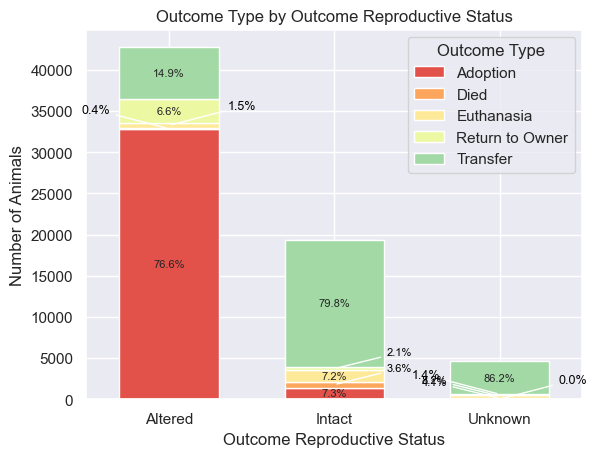

In [378]:
stacked_bar_chart('Outcome Reproductive Status', 'Outcome Type', cats)

# Cats that are altered at the time of outcome are much more likely to have an adopted outcome type than intact or unknown cats. This is likely because most shelters have a policy against adopting out intact animals. 
# So being spayed/neutered is unlikely to contribute to the adoption; correlation does not imply causation. 

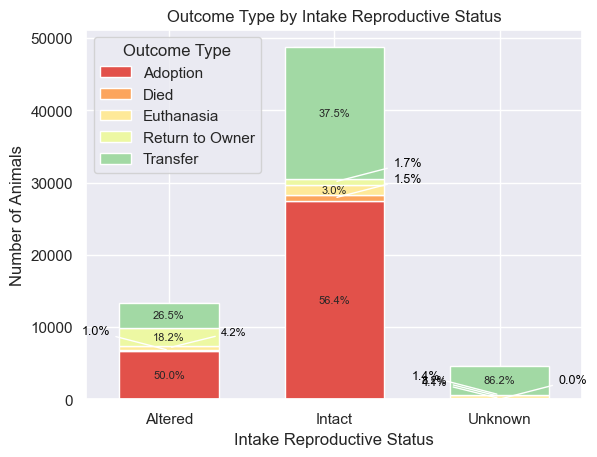

In [379]:
stacked_bar_chart('Intake Reproductive Status', 'Outcome Type', cats)

# Cats that are already spayed/neutered show a similar rate of adoption, which suggests reproductive status is not as important as the previous chart would suggest. This fits with 
# the consideration that the shelter policy is causing the higher "adoption rate" of altered animals. 

# Additionally, we can see that animals who are already spayed/neutered on intake have a higher change of being returned to an owner. Animals are often microchipped at the time
# of their spay/neuter surgery, so microchips might be a confounding factor that contributes to the higher "return to owner" rate for these animals.

# For both intake and outcome reproductive status, the animals with "unknown" status are much more likely to be transferring to another facility than otherwise. 
# This might be explained by an incomplete physical exam or choice not to spay/neuter for animals slated for transfer. 

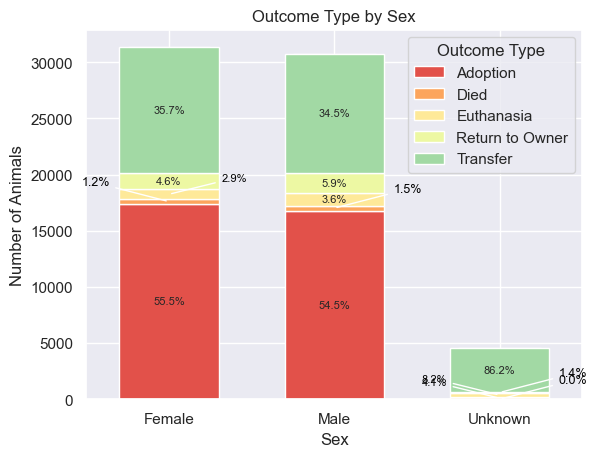

In [380]:
stacked_bar_chart('Sex', 'Outcome Type', cats)

# The heatmap in my profile suggested a weak correlation between outcome type & sex, but I suspect it was just noticing
# the "unknown" animals being much more likely to be transferred elsewhere. The outcome types among the male & female animals
# are very similar. 

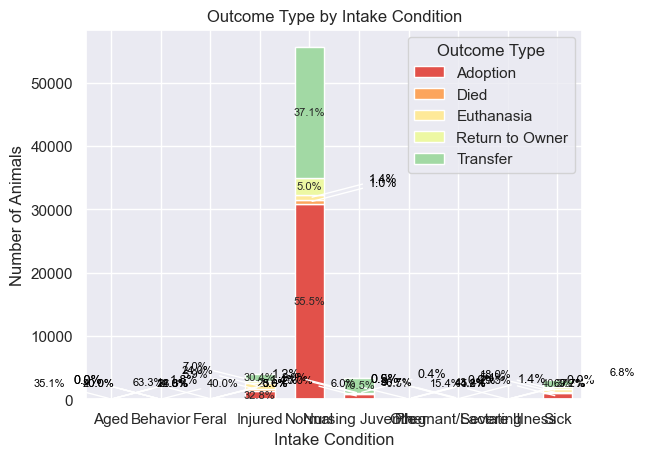

In [381]:
stacked_bar_chart('Intake Condition', 'Outcome Type', cats)

# This chart shows the problem of one group (the Intake Condition: Normal) being so overrepresented that the 
# other groups become impossible to interpret. If I wanted to correct this problem, I could balance my data
# and make this chart again. But since I'm just exploring and not balancing yet, I will just examine the other
# groups without the unbalanced, overrepresented one. I can still directly compare the percentages (ie. what
# percentage of Normal intakes ended up adopted vs the percentage adopted in another group)

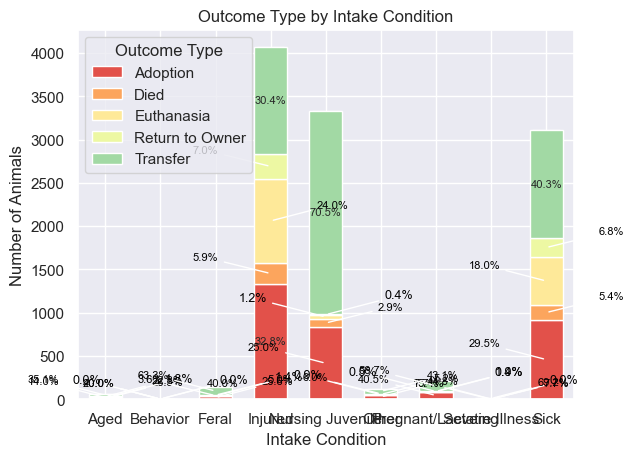

In [384]:
cats_without_normal_intakes = cats.loc[cats['Intake Condition'] != 'Normal']
stacked_bar_chart('Intake Condition', 'Outcome Type', cats_without_normal_intakes)

# Better - but the scale of animals in some of these smaller categories is still unwieldly. 
# Let's just look at a contingency table...

In [389]:
crosstab = pd.crosstab(cats['Intake Condition'], cats['Outcome Type'], normalize = False) # I don't love the default normalization, so I convert to percentages myself.
row_sums = crosstab.sum(axis = 1)
percentages = (crosstab.div(row_sums, axis = 0)) *100

percentages

# Even though my initial profile found only mild-moderate correlation between Intake condition & Outcome type, it makes logical sense that it would be important, and 
# the data fits with that when we take a closer looks. I suspect if I balanced the data before running the profile, this correlation would probably be much stronger
# It definitely looks like any not-normal animal has a lower adoption rate. The injured, sick, and aged animals have much higher euthanasia rates, and 
# almost all the not-normal intake conditions have higher transfer rates (suggesting they might be transferred to shelters/rescues more suitable for their specific condition). 

# Additionally, Aged, Behavior, and Severe Illness categories are much more likely to be returned to their owners. 
# I can think of a number of reasons this might be the case:
#   - the shelter knows the likelihood of adopting that animal out is lower, so they try harder to find a solution with the current owner
#   - the owner decides to palliate or euthanize the pet at home rather than putting it through the stress of the shelter system
#   - the owner decides to get medical/behavioral care for their pet elsewhere rather than relinquishing them
#   - alternately, it could be that the "return to owner" rates are lower for the other intake conditions because they are "diluted" by stray pets who never had an owner

# I cannot explain a 5% "return to owner" rate for supposedly feral animals. Unless "owner" in this case implies "the person who brought the feral, unowned animal to the shelter"
# Maybe these could be barn cats or colony cats that the "owner" is returning to wherever they found them. 
# It could also be that the "feral" intake condition is being applied to animals who aren't actually feral. 

Outcome Type         Adoption      Died  Euthanasia  Return to Owner  \
Intake Condition                                                       
Aged                26.315789  1.754386   14.035088        22.807018   
Behavior            40.000000  0.000000    0.000000        20.000000   
Feral               26.618705  1.438849    3.597122         5.035971   
Injured             32.751414  5.925744   23.973445         6.983034   
Normal              55.539581  0.959655    1.426903         4.995957   
Nursing Juvenile    24.977484  2.942059    1.230862         0.390273   
Other               44.827586  0.862069    5.172414         6.034483   
Pregnant/Lactating  40.465116  0.930233    0.465116         1.395349   
Severe Illness       0.000000  7.692308    7.692308        15.384615   
Sick                29.457115  5.428847   18.021201         6.778028   

Outcome Type         Transfer  
Intake Condition               
Aged                35.087719  
Behavior            40.000000  
Feral               63.309353  
Injured             30.366363  
Normal              37.077905  
Nursing Juvenile    70.459322  
Other               43.103448  
Pregnant/Lactating  56.744186  
Severe Illness      69.230769  
Sick                40.314809

Text(0.5, 1.0, 'Intake Age by Outcome Type')

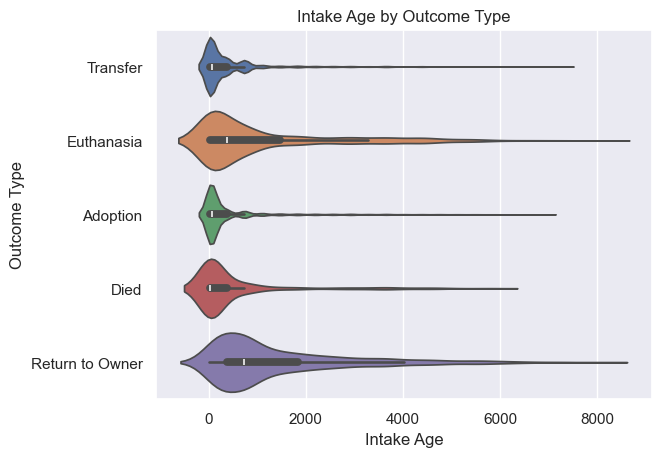

In [467]:
ax = sns.violinplot(x='Intake Age', y='Outcome Type', hue='Outcome Type', data=cats)
ax.set_title('Intake Age by Outcome Type', loc='center')

# Even though my profile showed a very mild correlation between intake age & outcome type, I wanted to look more closely because
# logic suggests an older animal might have a harder time getting adopted. 
# Because so many of the animals taken in by the shelter skew younger in age, we see most of the data concentrated there (almost all the pets are <5.5 years old - 2000 days)
# That said, you can see the average age of euthanized pets and pets returned to owner are older than the adoption age and transfer ages.
# The IQR of pets who end up euthanized or returned to their owners is also much wider than for Transfer/Adoption/Death outcomes 
# 
# Additionally, the animals that have died skew younger than those adopted, which suggests the neonatal death rate is higher than for other groups
# That's also supported by the contingency table above, which shows "nursing juvenile" cats have a 3% death rate (twice as high as "aged" animals and 3x higher than "normal" intake).

Text(0.5, 1.0, 'Duration of Stay by Outcome Type')

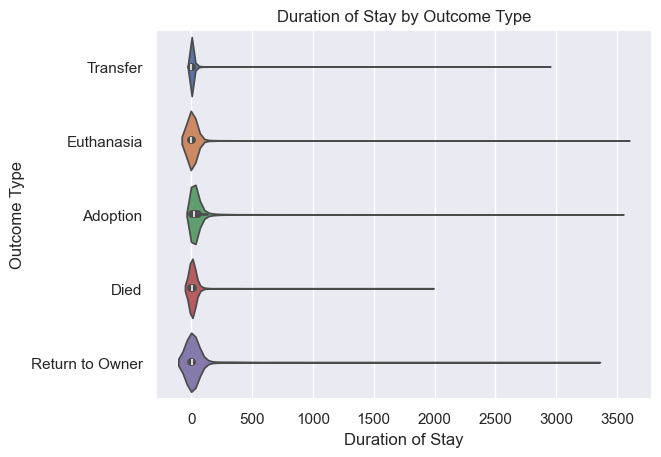

In [469]:
ax = sns.violinplot(x='Duration of Stay', y='Outcome Type', hue='Outcome Type', data=cats)
ax.set_title('Duration of Stay by Outcome Type', loc='center')

# Even though there was minimal correlation identified in the profile for Duration of Stay, I wanted to look
# more closely that this feature because it's another one that I could explain logically. With this violin plot, 
# I can see that the pets destined for transfer seem to do so very quickly, but otherwise, there is no clear change
# in duration of stay for each outcome type. And there are Duration of Stay outliers that conclude with each of the 
# outcome types. There could still be a mild correlation that is obscured because the data is not balanced for duration 
# of stay, but I don't feel like I have to use this as a feature. 

Text(0.5, 1.0, 'Distribution of Outcome Type over Intake Time')

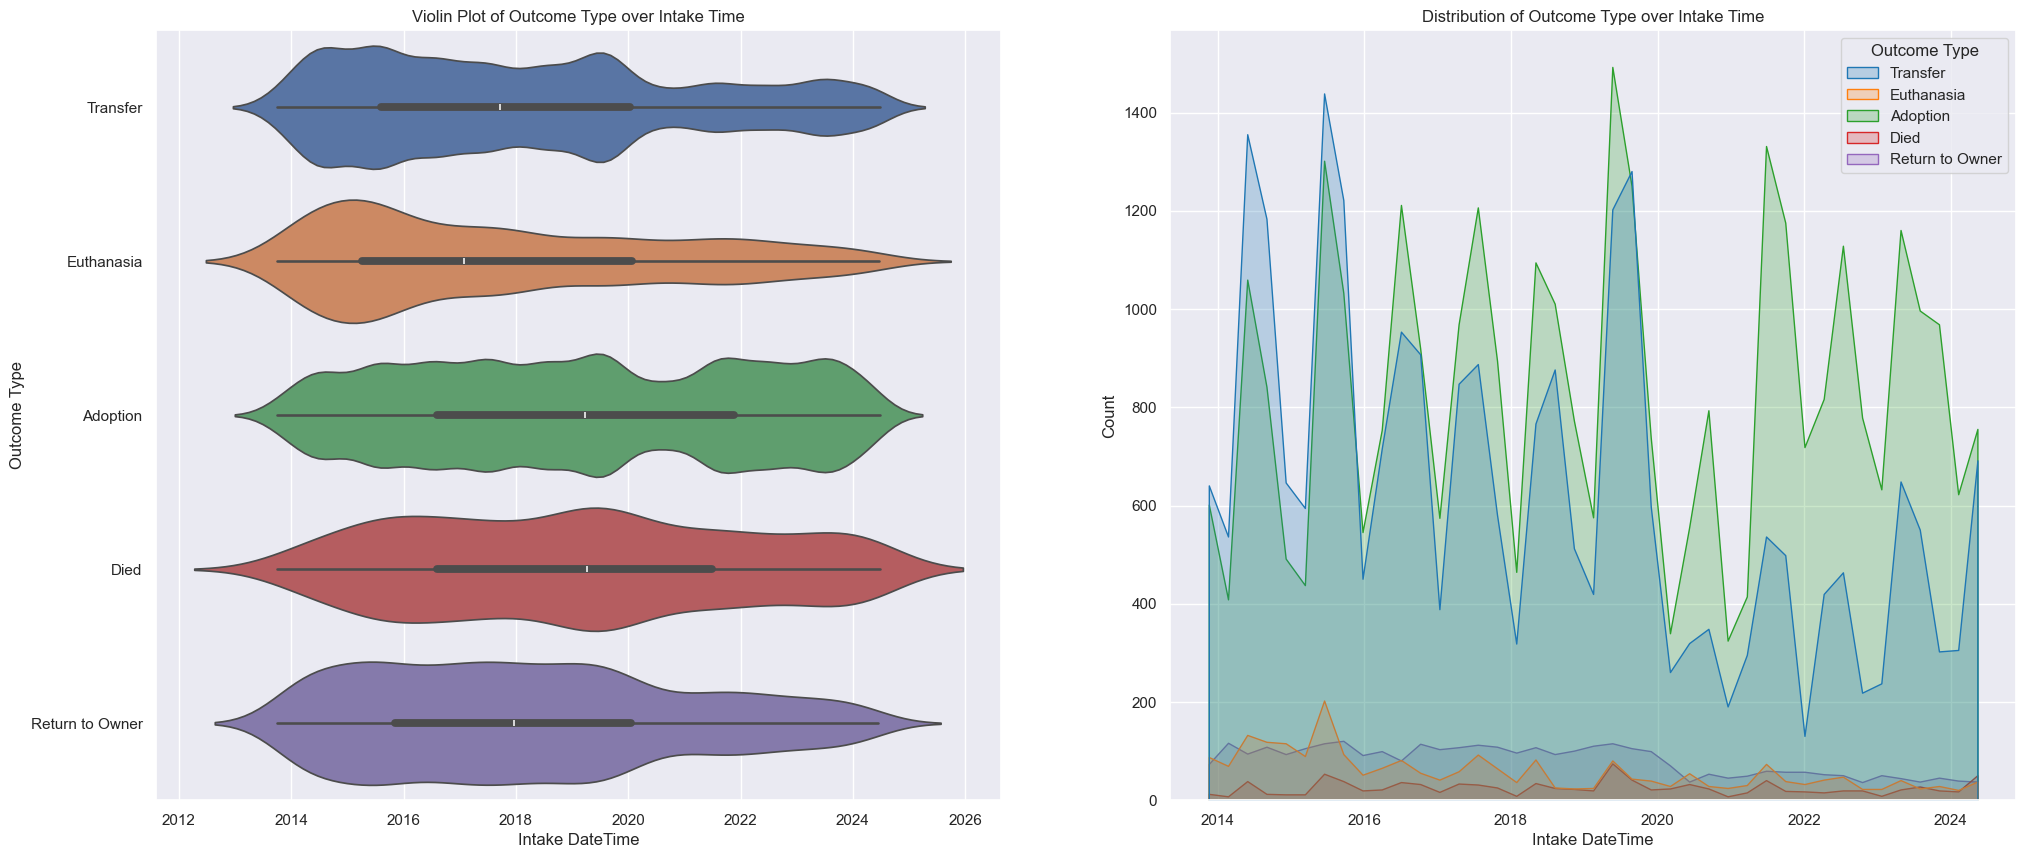

In [471]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
sns.violinplot(x='Intake DateTime', y='Outcome Type', hue='Outcome Type', data=cats, ax=axs[0], label = 'Violin Plot')
axs[0].set_title('Violin Plot of Outcome Type over Intake Time')
sns.histplot(data=cats, x= 'Intake DateTime', hue='Outcome Type', palette = 'tab10', kde = False, stat = 'count', element = 'poly', ax = axs[1], label = 'Distribution over Time')
axs[1].set_title('Distribution of Outcome Type over Intake Time')

# There's a lot of information to get out of these graphs, which show the trends in outcome types over time (intake time in this case)
# First, you can see on the distribution plot that there is definite periodicity to the adoption pattern; we'll see if this shows up on the outcome datetime plots as well. 
#   - This suggests a definite, predictable "busy period" for intakes depending on the season (possibly down to the month). This may or may not impact a specific cat's chance of getting adopted (since this shelter does not have a "time limit" before a pet is euthanized)
# Second, the shelter is performing fewer euthanasias over time. 
#   - On the left, we see the density increased in the 2014-2016 time period, with a gradual decline since. This fits with the fact that this shelter moved to a "no kill" paradigm starting in 2011.
#   - On the right, there is a spike in euthanasias in 2015. There was a panleukopenia outbreak in the shelter around this time that can explain this irregularity.
# Third, the shelter relies less on Transfers now than previous. This fits with some news I found regarding a change in contract between the shelter and a particularly large rescue that significantly decreased the number of transfers the rescue had to accept per year.
# Fourth, there has been a general decrease in "Return to Owner" outcomes over the last several years. 
# Fifth, The death rate is relatively consistent (and mildly decreaseing over time) with the exception of a period in 2019 that matches up with another outbreak of panleukopenia. 
# Lastly, you can clearly see the COVID pandemic's effect on the number of adoptions in the 2020-21 years. The adoption rate has since recovered, though the transfer rate and return to owner rates have not. 
#   - you can also see a spike in adoptions and transfers at the start of 2020, which fits with the "adoption boom" of "pandemic pets"

# Ultimately, even though this information is interesting, I don't think it will significantly impact the questions I'm focusing on right now. Perhaps a new pet is less likely to be transferred, euthanized, or returned to their previous owner, but ther rates seems relatively steady over the last several years. I would be curious to see if the model I develop would be different if I train it on data from pre-2020 vs post-2022 data. 

Text(0.5, 1.0, 'Distribution of Outcome Type over Outcome Time')

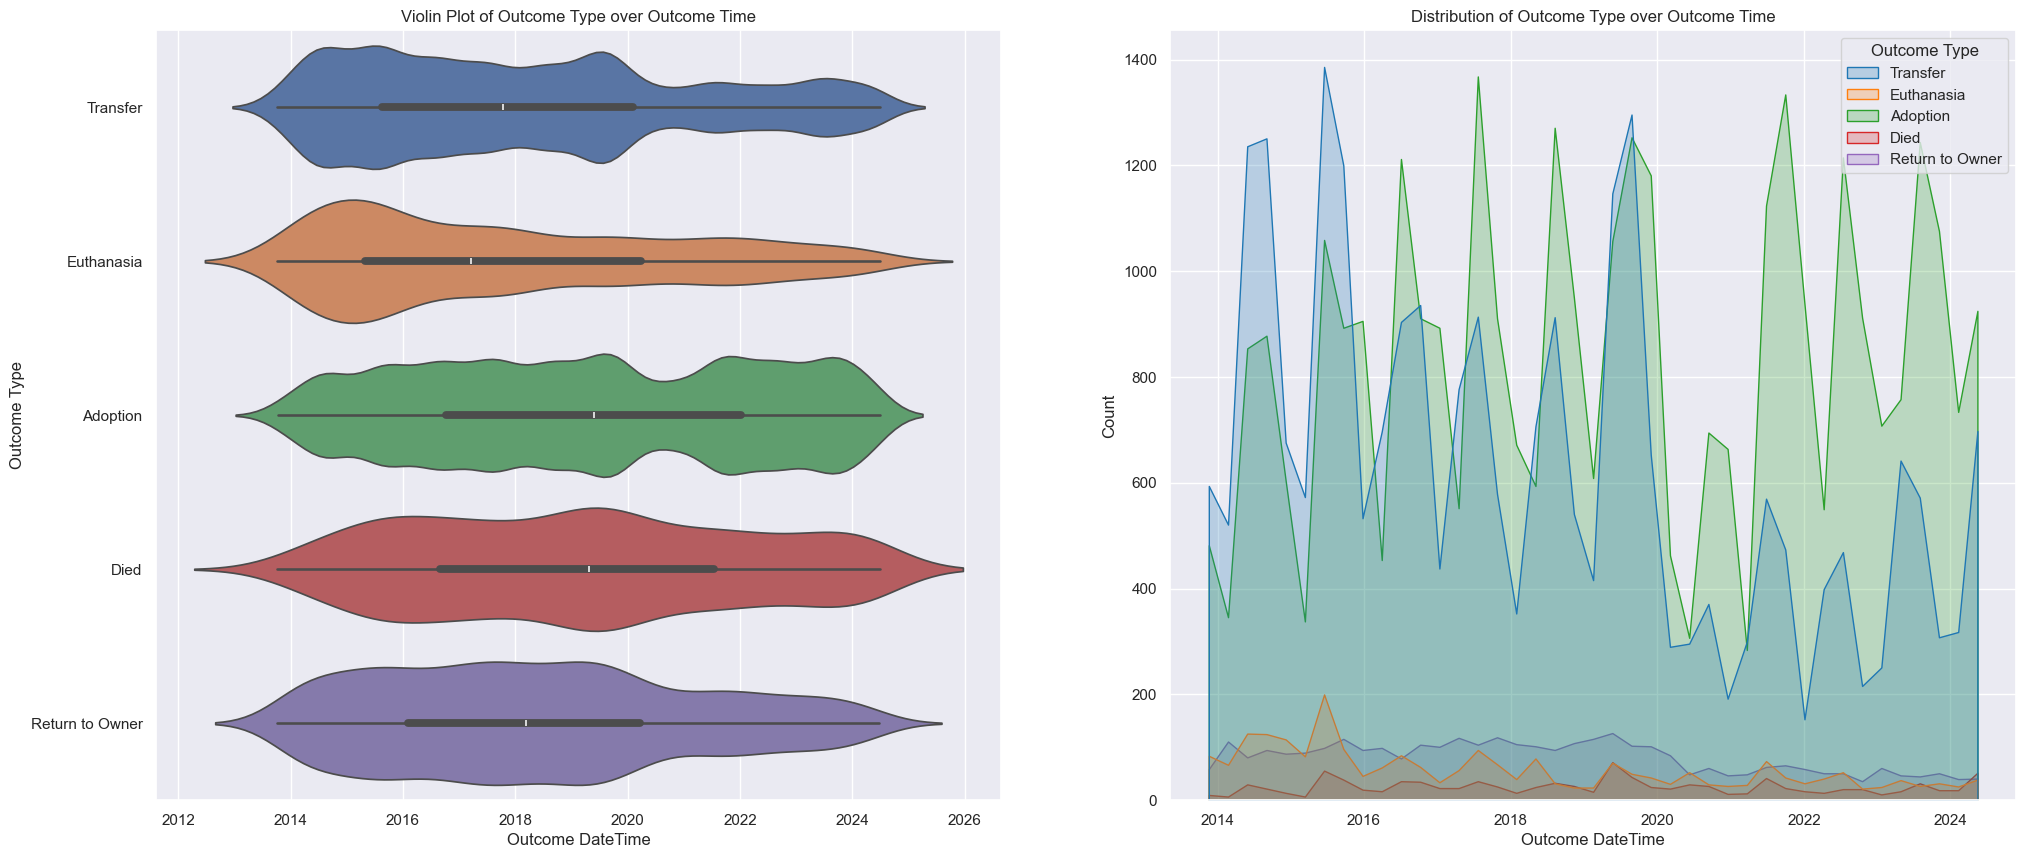

In [472]:
fig, axs = plt.subplots(1, 2, figsize=(24, 10))
sns.violinplot(x='Outcome DateTime', y='Outcome Type', hue='Outcome Type', data=cats, ax=axs[0], label = 'Violin Plot')
axs[0].set_title('Violin Plot of Outcome Type over Outcome Time')
sns.histplot(data=cats, x= 'Outcome DateTime', hue='Outcome Type', palette = 'tab10', kde = False, stat = 'count', element = 'poly', ax = axs[1], label = 'Distribution over Time')
axs[1].set_title('Distribution of Outcome Type over Outcome Time')

# This data mirrors much of what I found from the Intake DateTime examination, including the spikes in euthanasia and deaths matching up with panleukopenia outbreaks. 
# But again, I don't think there is much that will change my predictions for a given cat's outcome. 